# Fundamental Analysis of S&P500 Stocks Using K-Means Clustering
#### *Disclaimer: I am not a financial expert and this is not an investment advice. The project is for educational purposes only.

The stock market is a complex and dynamic investing platform that players of all portfolio sizes participate. Whether you are a retail investor or an institution, correctly valuing a company for its intrinsic value can be beneficial in deciding whether or not to invest in the company. In addition, traders often pay attention to technical indicators to try and predict short term price movements. Combined with individual research and public sentiment analysis, I believe that these analyses can offer beneficial insights to all investors who want better understanding of how the market behaves.

This Machine Learning Project will be utilizing historical market data of S&P500 stocks from IEX Cloud API, records ranging from 2009 to 2019.

This project is part one of a two-part project: 
1. Conduct K-means clustering on S&P500 stocks and characterize them according to industry/company fundamentals
2. Create unique XGBoost models based on the historical records of each clustered group to predict short term price movements

At the end of the project, investor will have better understanding of how the intrinsic values of the stocks align with the short term technical indicators.

## Outline
1. Pull recent quartlerly reports data for S&P500 companies from IEXCloud API
    * data needed: current debt, gross profit, EBITDA, debt to equity      ratio, liabilities, operating expense, pe ratio, average volume,      inventory turnover
2. Conduct Exploratory Data Analysis (EDA) on overall data (before clustering), impute any missing data, rid of any extreme outliers that may skew the model accuracy
    * read the head/tail of the dataframe
    * check out the value types of columns
    * df.shape to understand total number of rows and columns
    * drop/impute missing values xxx DONE
    * using sns.boxplots, identify outliers visually using IQR score technique
    * sns.pairplot and correlation heatmap <-- for better understanding of variables relationships
    * plot distribution plots
3. Conduct kNN clustering and divide the companies into different cluster groups
    * Why not just use industry categories to begin with?
    - Because clustering according to characteristics allows a company to react/behave differently from industry standards, it is more of a neutral way for the company's fundamentals to speak for itself. e.g. Amazon is an e-commerce company while also being a cloud computing, digital streaming, and AI company. It would be less pragmatic to classify Amazon as a e-commerce company and expect it to react to the ML models the same way any other e-commerce company does.
    - use scaler like StandardScaler() to scale the column values
        - The difference is that, in scaling, you’re changing the range of your data while in normalization you’re changing the shape of the distribution of your data.
    - https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
    - https://realpython.com/k-means-clustering-python/
    - https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02#:~:text=turn%20to%20StandardScaler.-,StandardScaler,values%20by%20the%20standard%20deviation.&text=StandardScaler%20results%20in%20a%20distribution%20with%20a%20standard%20deviation%20equal%20to%201.
    - elbow curve to find the right number of k's?
4. Tweak the kNN model as necessary according to entropy based measures, ranking feature importance
    * Optimize parameters using k-fold Cross Validation
    * tuning hyperparameters using GridSearchCV()
5. Deploy finalized groups of clustering that will be used to create unique XGBoost models

### Import Libraries

In [1047]:
import numpy as np
import pandas as pd
import requests
import xlsxwriter
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [1048]:
# import the sandbox token from IEX Cloud API
from secrets import IEX_sbtoken

In [1049]:
# test API call for quarterly financial data for Apple, Facebook, Tesla
symbol = 'AAPL'
base_url = 'https://sandbox.iexapis.com/stable/'
endpoint_path = f'stock/market/batch?symbols=aapl,fb,tsla&types=quote,balance-sheet,cash-flow,income&token={IEX_sbtoken}'

api_call = base_url + endpoint_path
data = requests.get(api_call).json()
data[symbol]['balance-sheet']['balancesheet'][0]['totalAssets']
data[symbol]['balance-sheet']['balancesheet'][0]['totalLiabilities']
data[symbol]['balance-sheet'].get('balancesheet','00')[0]['totalAssets']

355445575654

### Importing Data through Batch API Call

To cluster the stocks in S&P500, I will use the following fundamental indicators:
- free cashflow
- debt-to-equity ratio
- P/E ratio
- P/B ratio
- cost of revenue

Free cashflow: Net cash from operating activities for the period calculated as the sum of funds from operations, extraordinary items, and funds from other operating activities. In other words, cashflow measures how well the company generates cash to pay its debt obligations and fund its operating expenses.
https://www.investopedia.com/terms/c/cashflow.asp

Debt-to-equity ratio: Total liabilities divided by shareholder equity. If debt-to-equity ratio is too high, it’s a signal that your company may be in financial distress and unable to pay your debtors. But if it’s too low, it’s a sign that your company is over-relying on equity to finance your business, which can be costly and inefficient.
https://hbr.org/2015/07/a-refresher-on-debt-to-equity-ratio

P/E Ratio: The price-to-earnings ratio (P/E ratio) is a metric that helps investors determine the market value of a stock compared to the company's earnings. In short, the P/E ratio shows what the market is willing to pay today for a stock based on its past or future earnings.

P/B Ratio: The price-to-book ratio or P/B ratio measures whether a stock is over or undervalued by comparing the net value (assets - liabilities) of a company to its market capitalization.
https://www.investopedia.com/articles/fundamental-analysis/09/five-must-have-metrics-value-investors.asp

Cost of Revenue: The cost of revenue is the total cost of manufacturing and delivering a product or service to consumers.

There are many different ways to conduct fundamental analysis and which indicators to choose from, so keep in mind that these indicators are what I personally consider important when evaluating a company.

In [1050]:
# import the list of stocks from a csv file
sp500 = pd.read_csv('S&P500_Symbols.csv')

# set up an empty dataframe with symbol, name, and fundamentals as columns
my_columns = ['Symbol', 'Name', 'totalAssets', 'totalLiabilities', 'cashflow', 'costOfRevenue', 'peRatio', 'shareholderEquity', 'marketCap']
df = pd.DataFrame(columns=my_columns)

# divide the list into chunks of 100 stocks per list and do a batch request call
# Function sourced from:
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(liste, n):
    for i in range(0, len(liste), n):
        yield liste[i:i+n]

symbol_groups = list(chunks(sp500['Symbol'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))

for batch in symbol_strings:
    batch_api_call_url = f'https://sandbox.iexapis.com/stable/stock/market/batch?symbols={batch}&types=quote,balance-sheet,cash-flow,income&token={IEX_sbtoken}'
    data = requests.get(batch_api_call_url).json()    
    for symbol in batch.split(','):
        # check that all attributes--quote, balance sheet, income--are present for the symbol before appending
        balanceSheet = data[symbol]['balance-sheet'].get('balancesheet', False)
        cashFlow = data[symbol]['cash-flow'].get('cashflow', False)
        quote = data[symbol]['quote'].get('companyName', False)
        # if all attributes present, append each of the stock's ticker, name, total assets, total liabilities,
        # cashflow, cost of revenue, pe ratio, shareholder equity, and market capitalization
        if balanceSheet and cashFlow and quote:
            df = df.append(
                        pd.Series([symbol,
                                  data[symbol]['quote']['companyName'],
                                  data[symbol]['balance-sheet']['balancesheet'][0]['totalAssets'],
                                  data[symbol]['balance-sheet']['balancesheet'][0]['totalLiabilities'],
                                  data[symbol]['cash-flow']['cashflow'][0]['cashFlow'],
                                  data[symbol]['income']['income'][0]['costOfRevenue'],
                                  data[symbol]['quote']['peRatio'],
                                  data[symbol]['balance-sheet']['balancesheet'][0]['shareholderEquity'],
                                  data[symbol]['quote']['marketCap']
                                  ],
                                  index = my_columns),
                                  ignore_index = True)

In [1051]:
df.head()

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
0,MMM,3M Co.,48692517459,35410904405,8468345237,4435881114,19.99,13135528034,105625612592
1,AOS,A.O. Smith Corp.,3296121169,1376680867,581529724,522455463,28.06,1922961785,9702528722
2,ABT,Abbott Laboratories,69724997263,38019330368,4185244324,4140135578,68.44,32700248676,232359538810
3,ABBV,Abbvie Inc,151042931221,139444042108,12900608818,5119959858,24.27,15945044383,193918279675
4,ABMD,Abiomed Inc.,1479960000,168376491,196934885,43104496,76.18,1283881918,14606580440


## Data Preprocessing and Exploratory Data Analysis
Data preprocessing involves the following:
- Checking for and imputing null values, converting data types, data formatting

Exploratory Data Analysis is a connection to and an extension of data preprocessing by:
- Analyzing outliers, exploring variables' correlations, data scaling or data normalization

In [1052]:
df.isnull().values.any()

False

Out of 500 companies, 12 had missing data on either the balance sheet, cash flow, or quote. All other rows returned the requested data, so I will proceed with the exploratory data analysis to understand the returned data better before conducting K-means clustering.

In [1053]:
df.dtypes

Symbol                object
Name                  object
totalAssets           object
totalLiabilities      object
cashflow              object
costOfRevenue         object
peRatio              float64
shareholderEquity     object
marketCap             object
dtype: object

In [1054]:
# convert column data types to numeric values so that they can be scaled and computed
convert_cols = ['totalAssets', 'totalLiabilities', 'cashflow','costOfRevenue','peRatio','shareholderEquity','marketCap']
for col in convert_cols:
    df[col] = df[col].apply(pd.to_numeric, errors='ignore')
    
df.dtypes

Symbol                object
Name                  object
totalAssets            int64
totalLiabilities       int64
cashflow               int64
costOfRevenue          int64
peRatio              float64
shareholderEquity      int64
marketCap              int64
dtype: object

In [1055]:
# suppress scientific notation
pd.options.display.float_format = '{:.2f}'.format

# columns to do rudimentary scaling for easy interpretation, scale all variables in billions except p/e ratio
# distribution does not change
cols = ['totalAssets','totalLiabilities','cashflow','costOfRevenue','shareholderEquity','marketCap']
# numeric_df = df.drop(columns=['Symbol', 'Name'])
for col in cols:
    df[col] = df[col]/1000000000
df

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
0,MMM,3M Co.,48.69,35.41,8.47,4.44,19.99,13.14,105.63
1,AOS,A.O. Smith Corp.,3.30,1.38,0.58,0.52,28.06,1.92,9.70
2,ABT,Abbott Laboratories,69.72,38.02,4.19,4.14,68.44,32.70,232.36
3,ABBV,Abbvie Inc,151.04,139.44,12.90,5.12,24.27,15.95,193.92
4,ABMD,Abiomed Inc.,1.48,0.17,0.20,0.04,76.18,1.28,14.61
...,...,...,...,...,...,...,...,...,...
483,YUM,Yum Brands Inc.,6.61,14.86,0.36,0.36,30.71,-8.44,32.78
484,ZBRA,Zebra Technologies Corp. - Class A,5.42,3.33,0.99,0.69,51.40,2.20,25.70
485,ZBH,Zimmer Biomet Holdings Inc,25.10,12.32,0.81,0.58,-222.43,12.45,32.56
486,ZION,Zions Bancorporation N.A,78.90,72.87,0.56,0.05,22.04,7.77,8.35


In [1056]:
df

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
0,MMM,3M Co.,48.69,35.41,8.47,4.44,19.99,13.14,105.63
1,AOS,A.O. Smith Corp.,3.30,1.38,0.58,0.52,28.06,1.92,9.70
2,ABT,Abbott Laboratories,69.72,38.02,4.19,4.14,68.44,32.70,232.36
3,ABBV,Abbvie Inc,151.04,139.44,12.90,5.12,24.27,15.95,193.92
4,ABMD,Abiomed Inc.,1.48,0.17,0.20,0.04,76.18,1.28,14.61
...,...,...,...,...,...,...,...,...,...
483,YUM,Yum Brands Inc.,6.61,14.86,0.36,0.36,30.71,-8.44,32.78
484,ZBRA,Zebra Technologies Corp. - Class A,5.42,3.33,0.99,0.69,51.40,2.20,25.70
485,ZBH,Zimmer Biomet Holdings Inc,25.10,12.32,0.81,0.58,-222.43,12.45,32.56
486,ZION,Zions Bancorporation N.A,78.90,72.87,0.56,0.05,22.04,7.77,8.35


https://medium.com/@stallonejacob/data-science-scaling-of-data-in-python-ec7ad220b339
Scaling data is the process of increasing or decreasing the magnitude according to a fixed ratio, in simpler words you change the size but not the shape of the data

Scaling helps handling disparities in units and helps reduce computational expenses in the long run
- in ML eco space, it helps improve the performance of the model and reducing the values/models from varying widely

3 types of scaling:
- centering: the intercept represents the estiamte of the target when all predictors are at their mean value
- standardization: center the data, then we divide by the standard deviation to enforce that the standard deviation of the variable is one
- normalization: process of "normalizing" a variable to be between 0 and 1--squishing the variable to be constrained to a specific range (e.g. min-max scaling)

More on standardization:
- Intercepts are interpreted as the estimate when all predictors are at their mean value
- Coefficients are in units of standard deviations of the original predictors. This allows for direct comparison of the magnitude of impact between different predictors
- optimization methods (minimizing loss functions) are faster and more stable
- it is required for regularization penalties where the magnitude of coefficients for different predictors must have the same meaning
- in K-Nearest Neighbors methods it is necessary if you want features to contribute equally since these models use the distance between observations calculated from the features
- K-means clustering is affected by the scale of the data and standardizing the features will prevent variables from dominating simply based on their scale

Standardized scale interpretation:
- e.g. for 1 standard deviation increase in height estimates -0.95 years of age

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#robustscaler

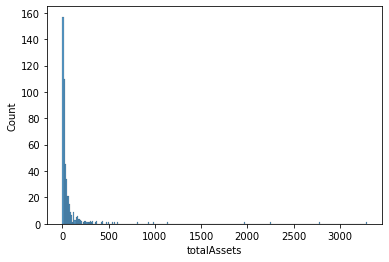

In [1057]:
sns.histplot(data=df.totalAssets)
plt.show()

distribution plots with kde: https://seaborn.pydata.org/tutorial/distributions.html

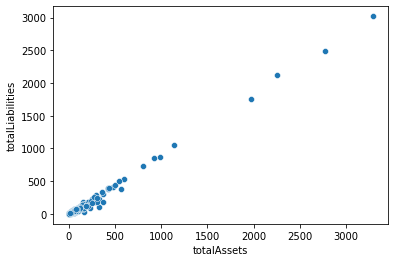

In [1058]:
sns.scatterplot(x=df.totalAssets, y=df.totalLiabilities)
plt.show()

In [1059]:
df.sort_values('totalAssets', ascending=False).head(5)

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
255,JPM,JPMorgan Chase & Co.,3291.60,3019.51,-52.10,0.63,19.17,279.73,454.84
60,BAC,Bank Of America Corp.,2773.75,2490.85,-17.32,1.42,17.58,269.79,305.59
104,C,Citigroup Inc,2249.81,2123.89,-22.49,2.30,12.88,199.22,136.24
469,WFC,Wells Fargo & Co.,1968.34,1760.69,25.13,0.79,96.71,189.68,154.74
206,GS,"Goldman Sachs Group, Inc.",1145.11,1054.23,-30.57,0.28,18.46,93.30,111.20


In [1060]:
df.sort_values('totalAssets').head(5)

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
289,MKTX,MarketAxess Holdings Inc.,1.28,0.36,0.18,0.00,77.33,0.91,20.95
4,ABMD,Abiomed Inc.,1.48,0.17,0.20,0.04,76.18,1.28,14.61
145,DPZ,Dominos Pizza Inc,1.66,4.92,0.38,0.63,33.60,-3.30,15.53
453,VRSN,Verisign Inc.,1.80,3.18,0.54,0.05,29.41,-1.45,22.95
386,ROL,"Rollins, Inc.",1.84,0.89,0.35,0.29,50.02,0.95,18.64


In [1061]:
df.describe()

,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
count,488.00,488.00,488.00,488.00,488.00,488.00,488.00
mean,81.66,65.50,2.75,3.15,14.02,16.32,70.84
std,259.97,236.01,7.24,8.98,181.28,31.60,181.47
min,1.28,0.17,-52.10,-0.11,-2624.17,-19.09,0.78
25%,10.72,6.37,0.54,0.15,14.07,3.05,16.21
50%,21.98,14.76,1.16,0.72,25.99,6.72,28.39
75%,57.15,41.27,2.85,2.38,40.01,15.53,60.17
max,3291.60,3019.51,68.34,101.62,1004.88,279.73,2259.29


In [1062]:
df.median()

totalAssets         21.98
totalLiabilities    14.76
cashflow             1.16
costOfRevenue        0.72
peRatio             25.99
shareholderEquity    6.72
marketCap           28.39
dtype: float64

From the histogram and the scatterpot, we could see that the data has a couple of extreme outliers that have 2-3 trillion dollars in assets and liabilities--mainly companies in the banking sector like JPMorgan and Bank of America. Moderate outliers lie around 700 billion to 1.5 trillion in assets and liabilities, with a mixture of companies in banking and insurance sectors.

Big bulk of of the companies in S&P500 range from 1~700 billion dollars in assets and liabilities. With the median of total assets around 22 billion and the mean around 82 billion according to the statistical summary, I can reverify that the data is skewed to the right by extreme outliers.

Using the IQR rule to identify outliers, the IQR range is 47.75 (58.40-10.65) and data points above 106.15 (58.4+47.75) billion dollars in total assets is considered an outlier.

In [1063]:
print("Number of outliers according to IQR rule:", df[df.totalAssets > 106.15].shape[0])

Number of outliers according to IQR rule: 70


https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/

As described in the statistical summary above, different fundamental features may vary significantly from each other due to their range of values and unit differences. As to dealing with outliers of these features, it is important to analyze them in the context of the machine learning algorithm we are using—which is K-means clustering. Whether to completely disregard the outliers and deciding thresholds in which we decide to disregard the outliers vary according to the context of the data analysis problem and the characteristics of K-means clustering algorithm.

Unlike OLS regression assumptions, K-means does not assume that the errors be normally distributed. However, K-Means may benefit from Gaussian normal distribution of the inputs as extreme outliers can result in inaccurate centroids. Therefore, like many machine learning algorithms, K-Means perform better with standardization.

Regular standardization method utilizes mean and standard deviation, leaving the data still vulnerable to overrepresented outliers. To work around this, I will use a robust scaler that ignores extreme outliers and uses median instead of mean to produce data that has zero mean and median and a standard deviation of 1. With robust scaler, I can specify the quantile_range parameter to determine outlier thresholds and because outliers are part of the “reality” of the data, I will use wider IQR ranges that allow fewer values to be considered outliers.

The whole point of using K-Means clustering to cluster the stocks in S&P500 is that I can come up with different strategies for different groups of characteristics of stocks. For example, instead of deploying the same regression model for both a company with 1 billion dollars in assets and a company with 3 trillion dollars in assets, I can deploy unique regression models that more accurately predict companies with differing feature vectors.

### Dealing with Outliers
Seeing that there are less than 10 extreme and moderate outliers, I have couple of options on dealing with them so that they don't hinder the performance of K-Means Clustering.

First option would be to just eliminate them before employing the clustering. This would help K-Means model produce more accurate centroids and reduce noise in the performance of the model.

Second option would be to replace the outliers with interquartile data points. This would reserve all the data but whether it would help the model differentiate the clusters better is the question.

Third option would be to use scaler transformations to standardize the input variables while ignoring the outliers. Standard Gaussian probability distributions of input variables tend to perform better with machine learning algorithms. 

### IQR Robust Scaler Transform

I've decided to first apply robust data scaling to the numeric variables and hope that the resulting variable has zero mean and median and a standard deviation of 1

In [1064]:
from sklearn.preprocessing import RobustScaler
# retrieve numeric input values only and drop symbol and name columns
data = df.values[:, 2:]

# instantiate robust scaler and transform the values
rscaler = RobustScaler()
data1 = rscaler.fit_transform(data)

# store the new, standardized dataframe
standard_df1 = pd.DataFrame(data1)
print(standard_df1.describe())

           0      1      2      3       4      5      6
count 488.00 488.00 488.00 488.00  488.00 488.00 488.00
mean    1.29   1.45   0.69   1.09   -0.46   0.77   0.97
std     5.60   6.76   3.12   4.02    6.99   2.53   4.13
min    -0.45  -0.42 -22.99  -0.37 -102.17  -2.07  -0.63
25%    -0.24  -0.24  -0.27  -0.25   -0.46  -0.29  -0.28
50%     0.00   0.00   0.00   0.00    0.00   0.00  -0.00
75%     0.76   0.76   0.73   0.75    0.54   0.71   0.72
max    70.42  86.12  29.00  45.20   37.74  21.88  50.74


The resulting summary statistics of scaled data shows the standard deviation to still be significantly higher. I proceed to play around with the parameters and the threshold for outliers and see if they get closer to the statistics I want.

In [1065]:
# scaling without centering the data resulted in mean closer to 1
rscaler = RobustScaler(with_centering=False, with_scaling=True,
                       # widen the IQR to detect more outliers
                      quantile_range=(3, 97))
data2 = rscaler.fit_transform(data)
standard_df2 = pd.DataFrame(data2)
print(standard_df2.describe())

           0      1      2      3      4      5      6
count 488.00 488.00 488.00 488.00 488.00 488.00 488.00
mean    0.19   0.17   0.16   0.16   0.06   0.19   0.23
std     0.62   0.63   0.43   0.45   0.80   0.37   0.59
min     0.00   0.00  -3.10  -0.01 -11.57  -0.22   0.00
25%     0.03   0.02   0.03   0.01   0.06   0.04   0.05
50%     0.05   0.04   0.07   0.04   0.11   0.08   0.09
75%     0.14   0.11   0.17   0.12   0.18   0.18   0.20
max     7.79   8.02   4.07   5.08   4.43   3.28   7.33


Widening the IQR to reduce more outliers resulted in standard deviations closer to 1 but at the cost of means closer to 0. As such, trying to apply robust scaling to data with too many extreme outliers skewing the scaling doesn't work.

As a result, I chose to outright remove the extreme outliers first using the IQR method (because the data distribution of input variables are far from normal).

In [1066]:
# sns.pairplot(df)
# plt.show()

Checking out the pair plots of all the columns, there are usually from 5 to 10 extreme upper outliers that may skew clustering performance--usually lying above the 98th percentile. There are also around 5 extreme lower outliers in cashflow and peRatio columns, lying below the 2nd percentile.

### Filtering Outliers

In [1067]:
# only including data points that are below 97.5th percentile per column
df_filtered = df.copy()

for col in df_filtered.columns:
    if col != 'Symbol' and col != 'Name':  
        upper_q = df_filtered[col].quantile(0.975)
        lower_q = df_filtered[col].quantile(0.01)
        df_filtered = df_filtered[(df_filtered[col] < upper_q) & (df_filtered[col] > lower_q)]

In [1068]:
df_filtered.reset_index(inplace=True, drop=True)
df_filtered

,Symbol,Name,totalAssets,totalLiabilities,cashflow,costOfRevenue,peRatio,shareholderEquity,marketCap
0,MMM,3M Co.,48.69,35.41,8.47,4.44,19.99,13.14,105.63
1,AOS,A.O. Smith Corp.,3.30,1.38,0.58,0.52,28.06,1.92,9.70
2,ACN,Accenture plc - Class A,40.05,20.52,1.68,8.07,32.71,18.31,178.33
3,ATVI,Activision Blizzard Inc,22.04,7.20,1.16,0.49,36.39,14.66,82.71
4,AAP,Advance Auto Parts Inc,12.54,8.45,0.84,1.42,24.99,3.84,11.73
...,...,...,...,...,...,...,...,...,...
303,XYL,Xylem Inc,8.82,5.62,0.47,0.78,79.92,2.89,17.73
304,ZBRA,Zebra Technologies Corp. - Class A,5.42,3.33,0.99,0.69,51.40,2.20,25.70
305,ZBH,Zimmer Biomet Holdings Inc,25.10,12.32,0.81,0.58,-222.43,12.45,32.56
306,ZION,Zions Bancorporation N.A,78.90,72.87,0.56,0.05,22.04,7.77,8.35


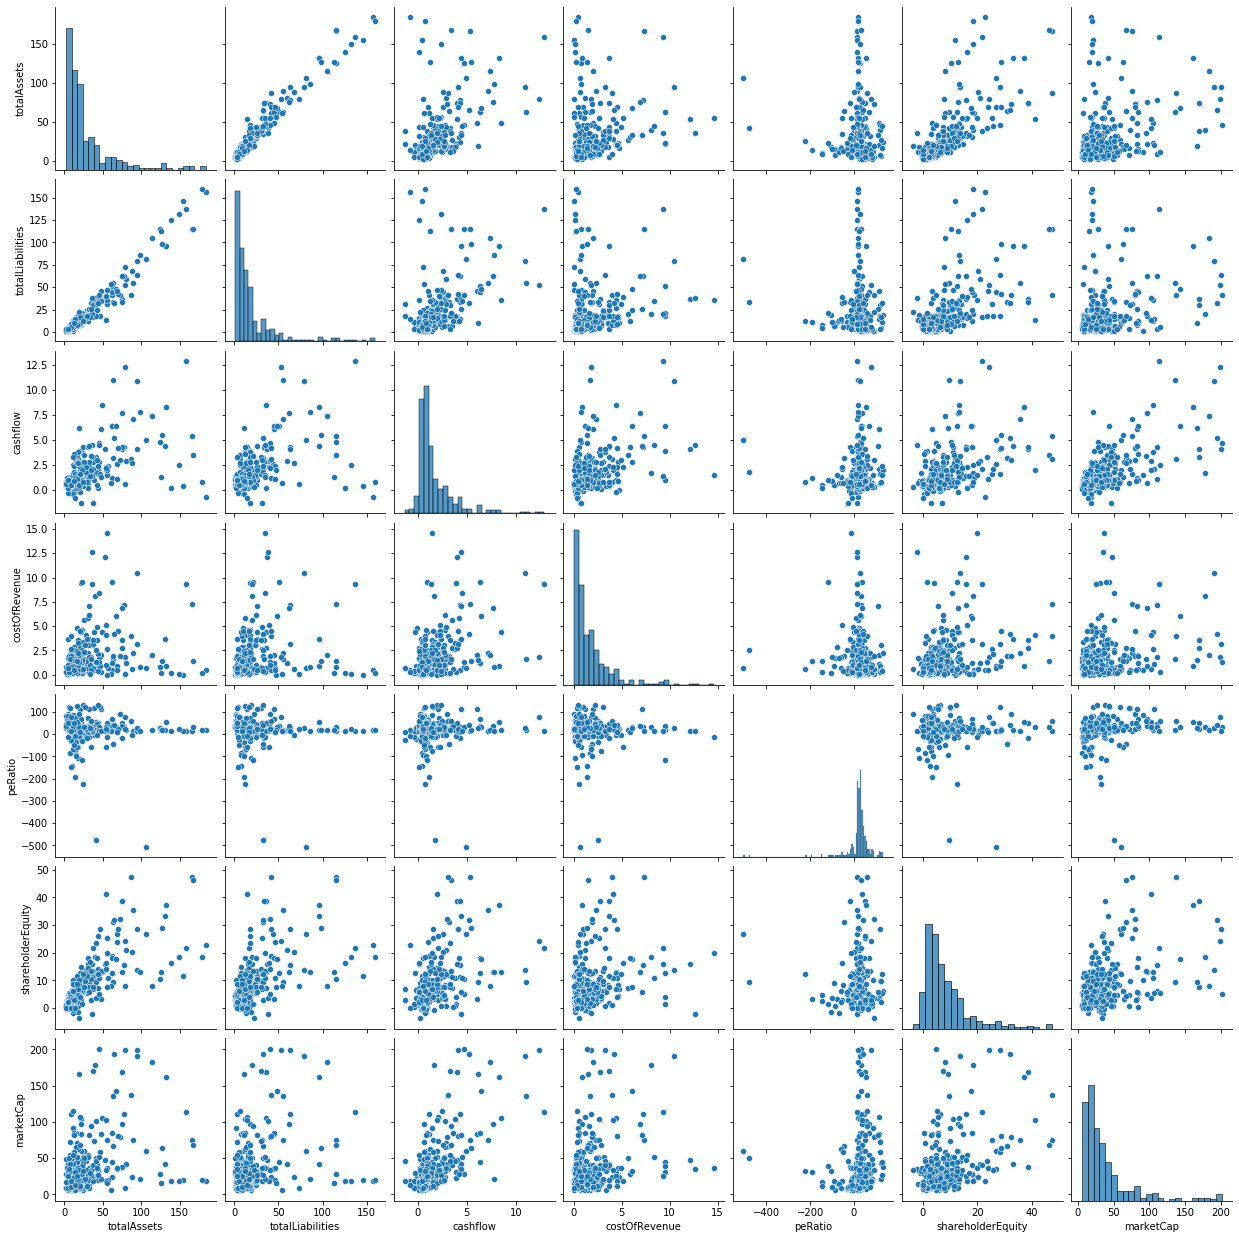

In [1069]:
sns.pairplot(df_filtered)
plt.show()

In [1070]:
data = df_filtered.values[:, 2:]

# instantiate robust scaler and transform the values
rscaler = RobustScaler()
data = rscaler.fit_transform(data)

# store the new, standardized dataframe
standardized_df = pd.DataFrame(data)
print(standardized_df.describe())

           0      1      2      3      4      5      6
count 308.00 308.00 308.00 308.00 308.00 308.00 308.00
mean    0.47   0.55   0.42   0.43  -0.27   0.35   0.49
std     1.34   1.63   1.20   1.21   2.64   1.08   1.38
min    -0.60  -0.61  -1.40  -0.56 -23.90  -1.17  -0.70
25%    -0.35  -0.37  -0.30  -0.31  -0.53  -0.33  -0.33
50%     0.00   0.00   0.00   0.00   0.00   0.00   0.00
75%     0.65   0.63   0.70   0.69   0.47   0.67   0.67
max     6.67   8.86   7.15   7.45   4.69   5.19   6.40


After getting rid of the upper and lower outliers, we can see that the distribution of the data is more interpretable and some of them are even closer to normal distribution. I will now calculate and eliminate some of the columns to create the final set of features. When applied robust scaling, you can see that the mean and the standard deviation are also closer to 0 and 1, respectively.

Before proceeding I need to address the sample size issue. After excluding data with missing features and eliminating outliers for all feature values, I ended up with 300 stocks out of 500 of S&P500 index. Although there is no set rule on how much data you need for cluster analysis, here is what I found regarding sample size:
https://medium.com/business-data-quality-analyst/sample-size-for-cluster-analysis-72260a40e41d

1. Some recommend a sample size of 60\*k and 70\*k with k being the number of features. With 6 features in total, I am recommended to have 360 to 420 records. 

2. Some recommend to factor the number of model parameters when coming up with the sample size. 

3. More powerful machine learning algorithms like deep learning methods tend to be nonlinear algorithms and require much more data for better prediction power. Fortunately, K-means clustering algorithm is a linear algorithm in essence is not suitable for complex data.

Perhaps importing more data from other indexes like Russell 2000 and Dow Jones will result in more interesting insights. However, my goal in this project is to simply cluster the stocks in S&P500 with the hopes of leading to more unique, accurate models that predict the price of these stocks in the next part using a regression algorithm. To try and combat the small sample size, I will build the clustering model with k-fold cross validation, robust scaling, and hyperparameters optimization to produce a robust and unbiased performance.

### Eliminate and Create Features for Clustering

In [1071]:
# # calculate debt-to-equity ratio and P/B ratio
# df_filtered['debtToEquity'] = df_filtered['totalLiabilities'] / df_filtered['shareholderEquity']
# df_filtered['pbRatio'] = df_filtered['marketCap'] / (df_filtered['totalAssets'] - df_filtered['totalLiabilities'])

# # drop unnecessary columns
# df_filtered.drop(columns=['totalAssets','totalLiabilities', 'shareholderEquity','marketCap'], inplace=True)

In [1072]:
# sns.pairplot(df_filtered)
# plt.show()

Originally, I was going to use 'totalAssets', 'totalLiabilities', 'shareholderEquity', and 'marketCap' features to create the debt-to-equity ratio and P/B ratio. In the process of doing so, however, I realized that such transformations result in even more outliers and may not necessarily help with reducing model complexity.

I decided to proceed with assessing the correlations among the features before building the clustering model.

### Correlation Matrix
- Discovering the relationships among features

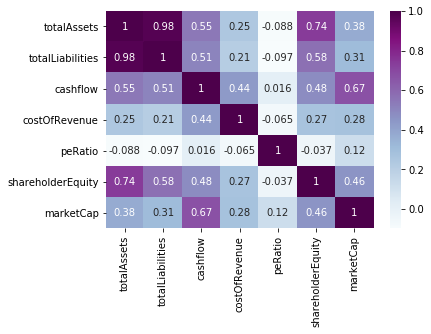

In [1073]:
sns.heatmap(df_filtered.drop(['Symbol','Name'], axis=1).corr(), annot=True, cmap='BuPu')
plt.show()

### Interpreting the Correlation Coefficients
Not surprisingly, company's total assets is almost perfectly positively correlated with it's total liabilities--disposing my assumption that they may have an inverse relationship. Another interesting relationship is company's shareholder equity and total assets & liabilities. Shareholder equity, by definition, is the company's total assets minus total liabilities. So it made sense that shareholder equity and total assets have a strong positive correlation but to find positive correlation with total liabilities as well is a bit confounding. 

It is my understanding that in a multivariate regression model, variables with multicollinearity issues tend to perform poorly as a result of overfitting. So we may want to either transform the variables or create a product of highly correlated variables as a solution. However, in K-Means clustering, collinearity is not an issue. I've decided to keep all features so that they can differentiate the data points as much as possible.

2/16 Tuesday Log:
- created new columns of ratios and dropped old ones, but reverted these operations because I had to first scale the data
- applied robust scaling to the data in the hopes of normalizing the data, failed
- decided to use IQR method to get rid of extreme outliers first
- *note: leave robust scaling for when actually implementing K-Means Clustering with cross validation

2/18 Thursday Log:
- use IQR method to get rid of extreme outliers of all features
- set aside the extreme outliers to a separate cluster group (manual separation)--note that the accuracy may be off because this wasn't separated on a holistic knowledge of the whole data set
- *note: even if a significant portion of the sample size is cut off due to outlier removal, nested cross validation and train/test split approaches produce robust and unbiased performance estimates regardless of the small sample size https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0224365
- create new columns of ratios and drop old ones
- plot pairplot and correlation heatmap and discover the relationships between varaibles

Mid-term Reflection:
- It is already pretty clear that it will be difficult to excavate any interesting insights from clustering these S&P500 stocks.
- I did, however, learn that K-Means clustering depends hugely on the distribution of the data and having more data to train always yields in better characterization of the clustering
- I learned how to to nested cross validation and scaling to combat the small sample size
- I also learned how to successfully request API calls
- By adding more features (increasing dimensionality) to the model, I learned that K-Means clustering may not result in truly meaningful clusters by itself, but it can aid regression models to perhaps create more unique, specific models according to the minute differences detected by clustering
- I thought I did my due diligence in researching how fundamental analysis is done, but I now know how heavily clustering algorithms relies on domain knowledge; adding more features that could better uniquely characterize the stocks may have been more helpful

2/19 Friday Goals:
- Implement K-Means clustering with cross validation and robust scaling
- Use GridSearchCV() to do hyperparameter optimization
- elbow curve to pick the best number of Ks
- how to better evalaute K-Means clustering models?